In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
% matplotlib inline


class Stock(object):
    def __init__(self, df=None, symbol='sp500'):
        self.df=df
        pass
    
    def print_df(self):
        print self.df
    
    def calculate_daily_returns(df):
        daily_returns=df.copy()
        daily_returns=(daily_returns/daily_returns.shift(1))-1
        return daily_returns[1:]
    
    def calculate_cumulative_returns(df):
        return (df/df.ix[0]) - 1

    def calculate_intrinsic_value(dividends_per_year, discount_rate):
        return dividends_per_year / discount_rate

    def calculate_book_value(total_assets, intangible_assets, liabilities):
        return total_assets - intangible_assets - liabilities

    def calculate_momentum(df, n):
        df=df/df.shift(n)
        return df[n:] - 1

    def calculate_sma(df, n):
        return (df/df.rolling(window=n,center=False).mean())[n:] - 1

    def calculate_bb(df, n):
        std=(df.rolling(window=n,center=False).std())[n:]
        ma=(df.rolling(window=n,center=False).mean())[n:]
        upper_bound=ma+2*std
        lower_bound=ma-2*std
        return upper_bound, lower_bound

    def normalize(df):
        return (df - df.mean())/df.std()
    
    
    
# get input datas
def get_stock_data(symbol):
    df = pd.read_csv('yahoo/{}.csv'.format(symbol), index_col='Date', parse_dates=True,
                     usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'],
                     na_values=['nan'])
    df.dropna()
    return df

def draw_rolling_statistics(df, symbol, window):
    rolling_mean = df[symbol].rolling(window=window).mean()
    rolling_std = df[symbol].rolling(window=window).std()
    bollinger_band_upper = rolling_mean + 2 * rolling_std
    bollinger_band_lower = rolling_mean - 2 * rolling_std
    plot = df[symbol].plot(title='{} rolling mean'.format(symbol), label='price')
    rolling_mean.plot(label='rolling mean', ax=plot)
    bollinger_band_upper.plot(label='upper band', ax=plot)
    bollinger_band_lower.plot(label='lower band', ax=plot)
    plot.set_xlabel("Date")
    plot.set_ylabel("Price")
    plot.legend(loc='upper left')
    plt.show()

def draw_scatter_plot(daily_returns, x_symbol, y_symbol):
    daily_returns.plot(kind='scatter', x=x_symbol, y=y_symbol, title='{} vs {} Daily return Scatter plot'.format(x_symbol, y_symbol))
    beta, alpha=np.polyfit(daily_returns[x_symbol], daily_returns[y_symbol], 1)
    plt.plot(daily_returns[x_symbol], beta * daily_returns[x_symbol] + alpha, '-', color='r')
    plt.show()

def draw_value_of_future_dollor(label, future_value, IR):
    time_years = np.linspace(0, 10, 21)
    present_value = future_value / (1 + IR) ** time_years
    plt.plot(time_years, present_value, linewidth=2.0, label=label)
    
def calculate_daily_returns(df):
    daily_returns=df.copy()
    daily_returns=(daily_returns/daily_returns.shift(1))-1
    return daily_returns[1:]

def calculate_cumulative_returns(df):
    return (df/df.ix[0]) - 1

def calculate_porfolio_value(df, start_val, symbols, allocs):
    portfolio_close_df=df[symbols]
    normalized_df=portfolio_close_df/portfolio_close_df.ix[0,:]
    alloced_df=normalized_df * allocs
    position_vals_df=alloced_df * start_val
    portfolio_val_df=position_vals_df.sum(axis=1)
    return portfolio_val_df

def calculate_intrinsic_value(dividends_per_year, discount_rate):
    return dividends_per_year / discount_rate

def calculate_book_value(total_assets, intangible_assets, liabilities):
    return total_assets - intangible_assets - liabilities

def calculate_market_capitalization(number_of_shares, price_per_share):
    return number_of_shares * price_per_share

def calculate_capm_stock_return(market_return, stock_alpha, stock_beta):
    if stock_alpha < 0:
        return -(stock_beta * market_return + stock_alpha)
    return stock_beta * market_return + stock_alpha

def calculate_capm_portfolio_return(market_return, allocs, alphas, betas):
    return (allocs * betas * market_return + allocs * alphas).sum()

def error(allocs, betas):
    for alloc in allocs:
        if alloc >= 1:
            return 1000000

    err = abs(allocs[0] * betas[0] + allocs[1] * betas[1]) + abs(sum(abs(allocs)) - 1)
    return err

def fit_line(betas, error_func):
    allocs = np.float32([.9, .1])
    result = spo.minimize(error_func, allocs, args=(betas,), method="SLSQP", options={'disp': True, 'maxiter': 1000})
    return result.x

def calculate_capm_weights_from_betas(betas):
    l_fit = fit_line(betas, error)
    print "Fitted line:C0={}, C1={}".format(l_fit[0], l_fit[1])

def calculate_momentum(df, n):
    df=df/df.shift(n)
    return df[n:] - 1

def calculate_sma(df, n):
    return (df/df.rolling(window=n,center=False).mean())[n:] - 1

def calculate_bb(df, n):
    std=(df.rolling(window=n,center=False).std())[n:]
    ma=(df.rolling(window=n,center=False).mean())[n:]
    upper_bound=ma+2*std
    lower_bound=ma-2*std
    return upper_bound, lower_bound

def normalize(df):
    return (df - df.mean())/df.std()

,FB,AAPL,sp500,GLD,GOOGL
2016-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05,0.004989,-0.025059,0.002012,0.002819,0.002752
2016-01-06,0.002336,-0.019570,-0.013115,0.014441,-0.002889


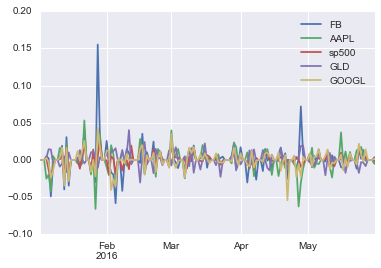

In [14]:
stocks = {}
symbols = ['sp500', 'GLD', 'AAPL', 'GOOGL', 'FB']
for symbol in symbols:
    stocks[symbol] = get_stock_data(symbol)
    

start_date = '2016-01-01'
end_date = '2016-05-31'
dates = pd.date_range(start_date, end_date)

adj_close_df = pd.DataFrame(index=dates)
for stock_name in stocks:
    stock = stocks[stock_name]
    temp_df = stock[['Adj Close']].rename(columns={'Adj Close': stock_name})
    adj_close_df = adj_close_df.join(temp_df)

adj_close_df.fillna(method='ffill', inplace='TRUE')
adj_close_df.fillna(method='bfill', inplace='TRUE')
adj_close_df.dropna()

normalized_adj_close_df = adj_close_df / adj_close_df.ix[0, :]

daily_returns=calculate_daily_returns(adj_close_df)
daily_returns.plot()

daily_returns.head()